In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
import colorednoise as cn
from natsort import natsorted
from tqdm import tqdm

In [2]:
def save_synthetic_data(data, filename):
    np.save(filename, data)

# Functions to define time series weekly

In [3]:
def create_sin(wavelength, time_limit, amplitude,phase,offset):
    x = np.arange(0, time_limit, 1)
    y = amplitude*np.sin(2*np.pi/wavelength*x+phase)+offset
    return y

In [4]:
def create_synthetic_ts_from_sin_weekly(periodicity:int,amplitude_weekday:int,amplitude_2_weekday:int ,amplitude_weekend :int,shift: int , noisyness=10**5, urllc=False,mMTC=False) -> np.array: 
    wavelength = periodicity*2
    time_limit = periodicity*2
    amplitude = amplitude_weekday
    phase = 0
    offset = amplitude_weekday
    amplitude_2 = amplitude_2_weekday
    day = periodicity*3
    

    sins1 = create_sin(wavelength, time_limit, amplitude,phase,offset) ### Sinus of the morning amplitude
    sinns2 = create_sin(wavelength, time_limit, amplitude_2,phase,offset)   ### Sinus of the afternoon amplitude

    #Creation of a day of the sime series
    total = np.zeros(3*periodicity)
    total[:periodicity] = sins1[periodicity:]
    total[1*periodicity:2*periodicity] = sins1[:periodicity]
    total[2*periodicity:] = sinns2[:periodicity]
    

    wavelength = periodicity*4
    
    amplitude_weekend = amplitude_weekend   
    offset=amplitude_weekend
   

    phase = 0
    

    sins1_wend=create_sin(wavelength, time_limit, amplitude_weekend,phase,offset)

    wavelength=periodicity*2 

    sinns3_wend=create_sin(wavelength, time_limit, amplitude_weekend,phase,offset)
    
    ##Creation of a weekend day of the sime series
    total_wend=np.zeros(periodicity*3)
    total_wend[:periodicity]=sinns3_wend[round(periodicity):]
    total_wend[periodicity:]=sins1_wend

    
    #Creation of a week of the sime series
    total_weekly=np.zeros(day*7)
    total_weekly[:day] = total
    total_weekly[day:day*2] = total
    total_weekly[day*2:day*3] = total
    total_weekly[day*3:day*4] = total
    total_weekly[day*4:day*5] = total
    total_weekly[day*5:day*6] = total_wend
    total_weekly[day*6:] = total_wend

    ## For URLLC, the weekly pattern is the same for all the week
    if urllc:
        total_weekly=np.zeros(day*7)
        total_weekly[:day] = total
        total_weekly[day:day*2] = total
        total_weekly[day*2:day*3] = total
        total_weekly[day*3:day*4] = total
        total_weekly[day*4:day*5] = total
        total_weekly[day*5:day*6] = total
        total_weekly[day*6:] = total

    ## For mMTC, the weekly pattern is random
    elif mMTC:
        total_weekly=np.random.normal(amplitude_weekday, noisyness, day*7)
        

    #Phase shift for the weekly pattern
    shift=random.randint(0,shift) ## 3600 segs = 1 hour, 5000 segs = 1.4 hours of phase shift
    total_weekly=np.roll(total_weekly,-shift)
    
    

    return total_weekly

## This function is to extend the pattern of each week to as many weeks as we want

In [5]:
def create_synthetic_ts_whole_range(weeks,periodicity:int,amplitude_weekday:int,amplitude_2_weekday:int ,amplitude_weekend :int,shift: int , noisyness=0,urllc=False,mMTC=False,random_amp=True) -> np.array: 

    days=periodicity*3
    total_weekly_noisy=np.zeros(days*7)
    total_weekly_noisy_whole_range=np.zeros(weeks*len(total_weekly_noisy))
    if random_amp:
            scaling_factor = np.random.uniform(0.75, 1.4)
            amplitude_weekday = amplitude_weekday*scaling_factor
            amplitude_2_weekday = amplitude_2_weekday*scaling_factor
            amplitude_weekend = amplitude_weekend*scaling_factor
    for i in range(weeks):
        
        total_weekly_noisy_whole_range[i*len(total_weekly_noisy):(i+1)*len(total_weekly_noisy)]=create_synthetic_ts_from_sin_weekly(periodicity,amplitude_weekday,amplitude_2_weekday ,
        amplitude_weekend ,shift, noisyness,urllc,mMTC)
    
    return total_weekly_noisy_whole_range


## Introduction of noise

In [6]:
def add_colored_noise(data,beta,deviation):
    y_simple = cn.powerlaw_psd_gaussian(beta, len(data))
    y_simple_scaled=y_simple*data*deviation
    added_noise=y_simple_scaled+data
    for i in range(len(added_noise)):
        if added_noise[i]<0:
            added_noise[i]=data[i]
    return added_noise


## Interpolate intersection of different weeks to have a smoother joint

In [7]:
def drop_outliers_intersection(data):
    ok = ~np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[~np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]

    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

## The time series is per second granularity, with this function we aggregate it to have per minute granularity

In [8]:
interval=60 # The data is produced per seconds, if we want granularity of 1 minute, we need to aggregate the data per 60 seconds
def aggregate_data(data,interval,n_weeks=9,Colored_Noise=True,beta=1.08,deviation=0.35):
    
    data_agg =np.zeros(round(len(data)/interval))
    for i in range(len(data_agg)):
        data_agg[i]=np.max(data[i*interval:(i+1)*interval])
    interval_drop=int(len(data)/(interval*n_weeks))
    for i in range(0,len(data_agg),interval_drop):
        data_agg[i:int(interval_drop*0.01)+i]=np.nan

    data_agg_no_outliers=drop_outliers_intersection(data_agg)
    if Colored_Noise:
        data_agg_no_outliers=add_colored_noise(data_agg_no_outliers,beta,deviation)
    return data_agg_no_outliers

# Main

In [9]:
weeks=9
periodicity=int((24*60*60)/3)

emBB_Bandwidth_ps= 60*10**6 # 60 Mbps
mMTC_Bandwidth_ps= 7*10**6 # 7 Mbps
uRLLC_Bandwidth_ps= 35*10**6 # 5 Mbps

afternoon_peak=0.78
weekend_peak=0.56


amplitude_weekday_embb = emBB_Bandwidth_ps
amplitude_2_weekday_embb = afternoon_peak * emBB_Bandwidth_ps
amplitude_weekend_embb = weekend_peak * emBB_Bandwidth_ps
amplitude_weekday_urllc = uRLLC_Bandwidth_ps
amplitude_2_weekday_urllc = afternoon_peak * uRLLC_Bandwidth_ps
amplitude_weekend_urllc = weekend_peak * uRLLC_Bandwidth_ps
amplitude_weekday_mmtc = mMTC_Bandwidth_ps
amplitude_2_weekday_mmtc = afternoon_peak * mMTC_Bandwidth_ps
amplitude_weekend_mmtc = weekend_peak * mMTC_Bandwidth_ps

shift = 5400 # 1.5 hours of phase shift

noisyness_embb = 0
noisyness_urllc = 0
noisyness_mmtc= 0


Text(0.5, 1.0, 'eMBB, mMTC and uRLLC traffic')

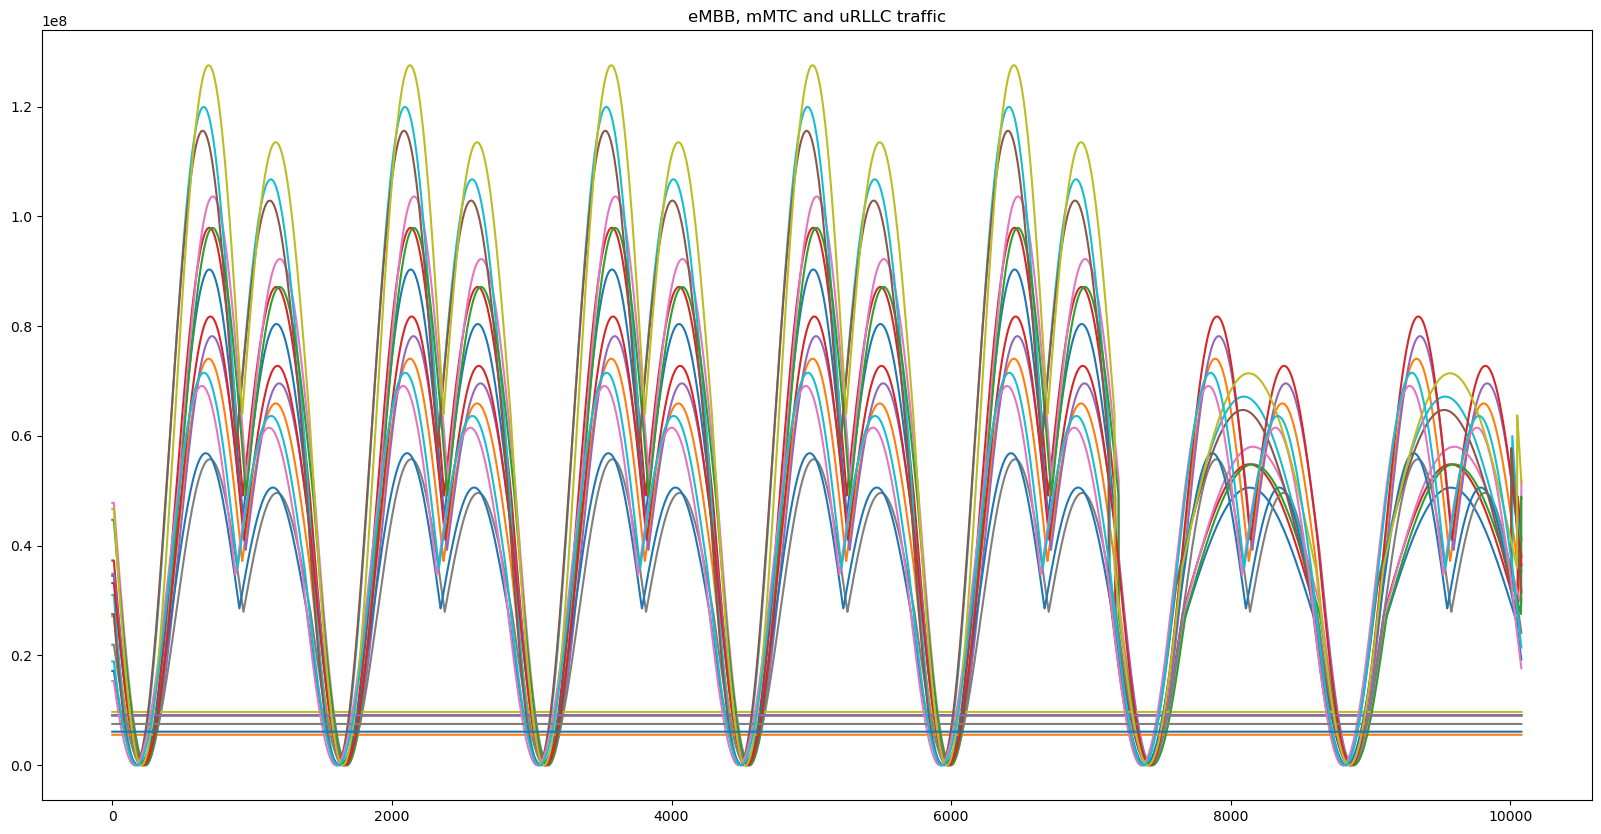

In [10]:
weeks=1
Colored_Noise= False
plt.figure(figsize=(20,10))
for i in range(7):
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_embb,amplitude_2_weekday=amplitude_2_weekday_embb 
    ,amplitude_weekend =amplitude_weekend_embb,shift= shift , noisyness=noisyness_embb),interval,Colored_Noise=Colored_Noise))
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_urllc,amplitude_2_weekday=amplitude_2_weekday_urllc 
    ,amplitude_weekend =amplitude_weekend_urllc,shift= shift , noisyness=noisyness_urllc,urllc=True),interval,Colored_Noise=Colored_Noise))
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_mmtc,amplitude_2_weekday=amplitude_2_weekday_mmtc 
    ,amplitude_weekend =amplitude_weekend_mmtc,shift= shift , noisyness=noisyness_embb,mMTC=True),interval,Colored_Noise=Colored_Noise))
plt.title('eMBB, mMTC and uRLLC traffic')

Text(0.5, 1.0, 'eMBB, mMTC and uRLLC traffic')

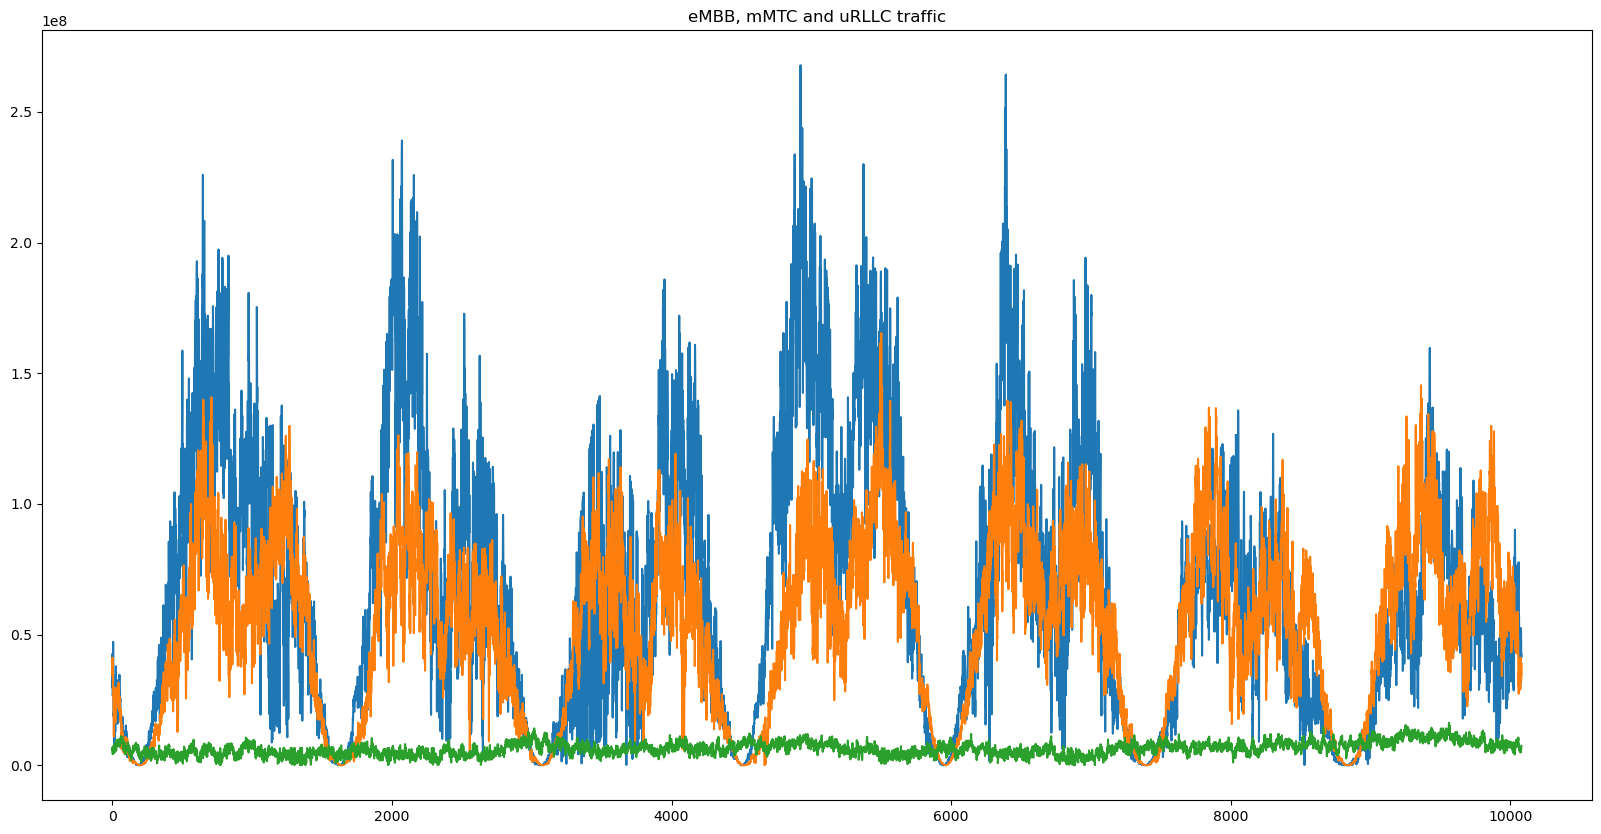

In [16]:
weeks=1
Colored_Noise= True
plt.figure(figsize=(20,10))
for i in range(1):
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_embb,amplitude_2_weekday=amplitude_2_weekday_embb 
    ,amplitude_weekend =amplitude_weekend_embb,shift= shift , noisyness=noisyness_embb),interval,Colored_Noise=Colored_Noise))
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_urllc,amplitude_2_weekday=amplitude_2_weekday_urllc 
    ,amplitude_weekend =amplitude_weekend_urllc,shift= shift , noisyness=noisyness_urllc,urllc=True),interval,Colored_Noise=Colored_Noise))
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_mmtc,amplitude_2_weekday=amplitude_2_weekday_mmtc 
    ,amplitude_weekend =amplitude_weekend_mmtc,shift= shift , noisyness=noisyness_embb,mMTC=True),interval,Colored_Noise=Colored_Noise))
plt.title('eMBB, mMTC and uRLLC traffic')

Text(0.5, 1.0, 'eMBB, mMTC and uRLLC traffic')

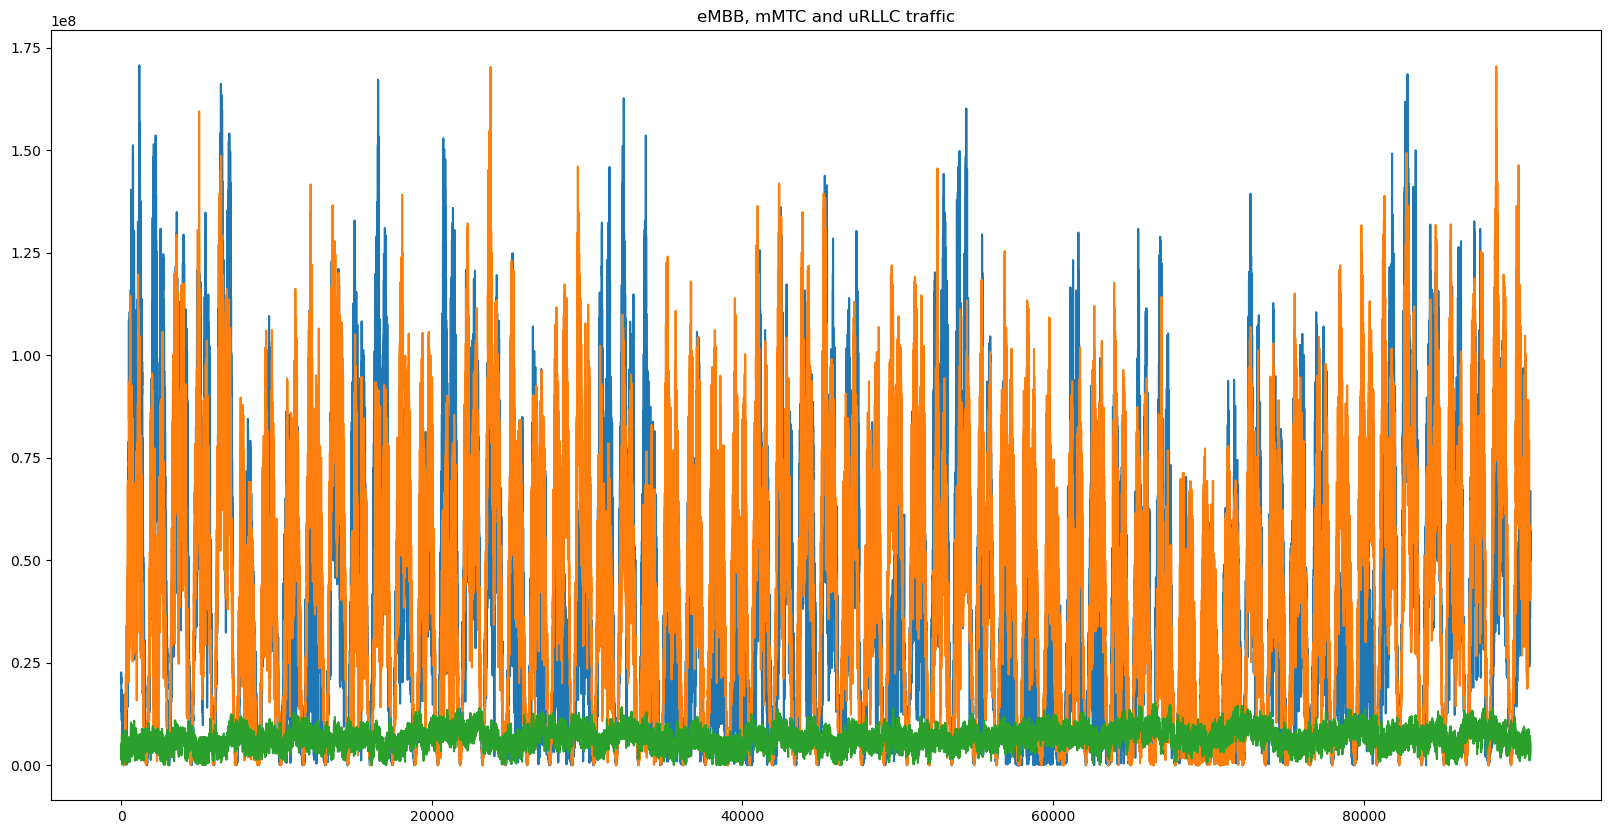

In [17]:
weeks=9
Colored_Noise= True
plt.figure(figsize=(20,10))
for i in range(1):
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_embb,amplitude_2_weekday=amplitude_2_weekday_embb 
    ,amplitude_weekend =amplitude_weekend_embb,shift= shift , noisyness=noisyness_embb),interval,Colored_Noise=Colored_Noise))
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_urllc,amplitude_2_weekday=amplitude_2_weekday_urllc 
    ,amplitude_weekend =amplitude_weekend_urllc,shift= shift , noisyness=noisyness_urllc,urllc=True),interval,Colored_Noise=Colored_Noise))
    plt.plot(aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_mmtc,amplitude_2_weekday=amplitude_2_weekday_mmtc 
    ,amplitude_weekend =amplitude_weekend_mmtc,shift= shift , noisyness=noisyness_embb,mMTC=True),interval,Colored_Noise=Colored_Noise))
plt.title('eMBB, mMTC and uRLLC traffic')

# Save synthetic Data

In [ ]:

Colored_Noise= True

savepath = '/home/user/Synthetic_Data/'
weeks=9

for i in tqdm(range(7)):
    data_emmb=aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_embb,amplitude_2_weekday=amplitude_2_weekday_embb 
    ,amplitude_weekend =amplitude_weekend_embb,shift= shift , noisyness=noisyness_embb),interval,Colored_Noise=Colored_Noise)
    
    #if np.min(data_emmb)<0:
    while np.min(data_emmb)<0:
        data_emmb=aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_embb,amplitude_2_weekday=amplitude_2_weekday_embb 
        ,amplitude_weekend =amplitude_weekend_embb,shift= shift , noisyness=noisyness_embb),interval,Colored_Noise=Colored_Noise)
        
    save_synthetic_data(data_emmb,f'{savepath}/emBB_{i}_noisy_agg_{interval}_s.npy')
for i in tqdm(range(7)):
    data_urrlc=aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_urllc,amplitude_2_weekday=amplitude_2_weekday_urllc
     ,amplitude_weekend =amplitude_weekend_urllc,shift= shift , noisyness=noisyness_urllc,urllc=True),interval)
    while np.min(data_urrlc)<0:
        data_urrlc=aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_urllc,amplitude_2_weekday=amplitude_2_weekday_urllc
         ,amplitude_weekend =amplitude_weekend_urllc,shift= shift , noisyness=noisyness_urllc,urllc=True),interval,Colored_Noise=Colored_Noise)
    save_synthetic_data(data_urrlc,f'{savepath}/uRLLC_{i}_noisy_agg_{interval}_s.npy')
for i in tqdm(range(6)):
    data_mmtc=aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_mmtc,amplitude_2_weekday=amplitude_2_weekday_mmtc 
    ,amplitude_weekend =amplitude_weekend_mmtc,shift= shift , noisyness=noisyness_mmtc,mMTC=True),interval,Colored_Noise=Colored_Noise)
    while np.min(data_mmtc)<0:
        data_mmtc=aggregate_data(create_synthetic_ts_whole_range(weeks,periodicity=periodicity,amplitude_weekday=amplitude_weekday_mmtc,amplitude_2_weekday=amplitude_2_weekday_mmtc 
        ,amplitude_weekend =amplitude_weekend_mmtc,shift= shift , noisyness=noisyness_mmtc,mMTC=True),interval,Colored_Noise=Colored_Noise)
    save_synthetic_data(data_mmtc,f'{savepath}/mMTC_{i}_noisy_agg_{interval}_s.npy')
    
    
    